### Дипломная работа Александра Соколова

#### Анализ моделей градиентного бустинга LightGBM и CatBoost
Кернел 5 из 5 в разделе ML (отредактирован 21.04.2021)
---

# 1. Импорт библиотек, инициализация глобальных констант
## 1.1. Импорт библиотек

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import tqdm

from sklearn.model_selection import train_test_split, KFold

import lightgbm as lgb

import pickle

np.warnings.filterwarnings('ignore')

In [2]:
import utils_21042021 as utils

## 1.2. Глобальные константы

In [3]:
# CURRENT_DIR = './'  # имя текущей директории для локальной машины 
CURRENT_DIR = '../'  # имя текущей директории для каггл

PATH_TO_MODELS = CURRENT_DIR + 'input/models-booster-alfabattle2-sandbox/'

PATH_TO_WORKDIR = CURRENT_DIR + 'working/'

In [4]:
!pip freeze > requirements.txt

# 2. Вспомогательные функции

In [5]:
def func_border(a, border):
    """
    функция применяется для создания бинарного вектора из вектора прогнозов по заданной границе
    :border - граница вероятности выше которой относим к дефолтным (1) ниже 0
    """
    if a > border:
        return 1
    else:
        return 0
vfunc = np.vectorize(func_border)

# 3. Импорт данных и моделей
---
## 3.1 Импорт агрегированных данных после препроцессинга
(препроцессинг проводился в [первом кернеле](https://www.kaggle.com/sokolovaleks/sf-dst-10-diplom-1-ml-sokolov))

In [6]:
%%time
merged_train_data = pd.read_csv('../input/alfabattle2-sandbox/preproc_data_for_boosting/preproc_data_for_boosting/merged_data.csv')
merged_test_data = pd.read_csv('../input/alfabattle2-sandbox/preproc_data_for_boosting/preproc_data_for_boosting/merged_test_data.csv')

CPU times: user 24.5 s, sys: 2.25 s, total: 26.7 s
Wall time: 36.8 s


## 3.2 Импорт предобученных моделей бустинга (LightGBM и CatBoost) 
(препроцессинг проводился в [втором (LightGBM)](https://www.kaggle.com/sokolovaleks/sf-dst-10-diplom-2-ml-sokolov) и [третьем (CatBoost)](https://www.kaggle.com/sokolovaleks/sf-dst-10-diplom-3-ml-sokolov) кернелах)

In [7]:
%%time
models_LGBM = []
feats_models = []
subs_models = []
for i_model in range(1,5,1):
    temp_list_models = []
    for i_count_model in range(1,6,1):
        path_to_model = f'model{i_model}/model{i_model}_{i_count_model}.txt'
        model = lgb.Booster(model_file=PATH_TO_MODELS + path_to_model)
        temp_list_models.append(model)
        
    models_LGBM.append(temp_list_models)
    path_to_feats = f'model{i_model}/feats_model{i_model}.pickle'
    with open(PATH_TO_MODELS + path_to_feats, 'rb') as f:
        feats = pickle.load(f)
    feats_models.append(feats)
    path_to_sub = f'model{i_model}/sub_model{i_model}.csv'
    sub = pd.read_csv(PATH_TO_MODELS + path_to_sub)
    subs_models.append(sub)

CPU times: user 3.32 s, sys: 102 ms, total: 3.42 s
Wall time: 2.18 s


## 3.3 Проверка импорта моделей

In [8]:
%%time
for i_models, models in enumerate(models_LGBM):
    score = np.zeros(len(merged_test_data))
    desc_str=f'Прогноз модели номер := {i_models+1} по фолдам:'
    for model in tqdm.tqdm_notebook(models,desc=desc_str):
        score += model.predict(merged_test_data[feats_models[i_models]]) / len(models)
    print(f'Кол-во переменных для модели:= {len(feats_models[i_models])}')
    submission = pd.DataFrame({
        'app_id' : merged_test_data.app_id.values,
        'score': score
    }) 
    submission['score_true']= subs_models[i_models].score
    submission['diff']= submission['score'] - submission['score_true']
    max_ = submission['diff'].max()
    min_ = submission['diff'].min()
    mean_ = submission['diff'].mean()
    print(f'Максимум, минимум и среднее от ошибки прогноза:= {max_:.4f}, {min_:.4f} ,{mean_:.4f}')

Прогноз модели номер := 1 по фолдам::   0%|          | 0/5 [00:00<?, ?it/s]

Кол-во переменных для модели:= 127
Максимум, минимум и среднее от ошибки прогноза:= 0.0000, 0.0000 ,0.0000


Прогноз модели номер := 2 по фолдам::   0%|          | 0/5 [00:00<?, ?it/s]

Кол-во переменных для модели:= 64
Максимум, минимум и среднее от ошибки прогноза:= 0.0000, 0.0000 ,0.0000


Прогноз модели номер := 3 по фолдам::   0%|          | 0/5 [00:00<?, ?it/s]

Кол-во переменных для модели:= 59
Максимум, минимум и среднее от ошибки прогноза:= 0.0000, 0.0000 ,0.0000


Прогноз модели номер := 4 по фолдам::   0%|          | 0/5 [00:00<?, ?it/s]

Кол-во переменных для модели:= 52
Максимум, минимум и среднее от ошибки прогноза:= 0.0000, 0.0000 ,0.0000
CPU times: user 9min 41s, sys: 4.16 s, total: 9min 45s
Wall time: 2min 36s


# 4. Анализ первой модели (1)
---
## 4.1 Расчет прогноза дефолта 

In [9]:
targets = merged_train_data.flag

In [10]:
%%time
features = feats_models[0]
lgb_models = models_LGBM[0]

targets_pred_broba = np.zeros(len(merged_train_data))

for model in tqdm.tqdm_notebook(lgb_models, desc='Прогноз по модели обученной на 5 фолдах:'):
    targets_pred_broba += model.predict(merged_train_data[features])/ len(lgb_models)

Прогноз по модели обученной на 5 фолдах::   0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 4min 38s, sys: 4.6 s, total: 4min 42s
Wall time: 1min 18s


## 4.3 Расчет бинарного вектора прогноза (targets_pred) из вероятностного прогноза (pred_proba)

In [11]:
sum_defolt_train = targets.sum()
sum_all_train = len(targets)

In [12]:
sort_pred = sorted(targets_pred_broba)
border = sort_pred[sum_all_train-sum_defolt_train]
targets_pred = vfunc(targets_pred_broba, border)

In [13]:
# в первый раз инициируем глобальную переменную с предыдущим скором нулевыми значениями
utils.last_pred = np.zeros((4,len(targets)))

## 4.4 Метрики, матрицы ошибок и кривые

In [14]:
utils.test_last_pred(targets, targets_pred, targets_pred_broba,len(features))
df_metrics = utils.all_metrics(targets, targets_pred, targets_pred_broba,len(features))

,Значение,Дельта с предыдущим,Описание
Кол-во признаков,127.000000,0.0,
accuracy,0.956028,0.0,(TP+TN)/(P+N)
balanced accuracy,0.590024,0.0,сбалансированная accuracy
precision,0.202664,0.0,точность = TP/(TP+FP)
recall,0.202656,0.0,полнота = TP/(TP+FN)
Ошибка II рода,0.797344,0.0,1 - полнота
f1_score,0.202660,0.0,среднее гармоническое точности и полноты
roc_auc,0.796315,0.0,площадь под ROC-кривой
roc_prc,0.137881,0.0,площадь под PC-кривой


In [15]:
df_metrics = df_metrics.rename(columns={'Значение':'model1'})
df_metrics.drop(['Дельта с предыдущим', 'Описание'], axis=1, inplace=True)

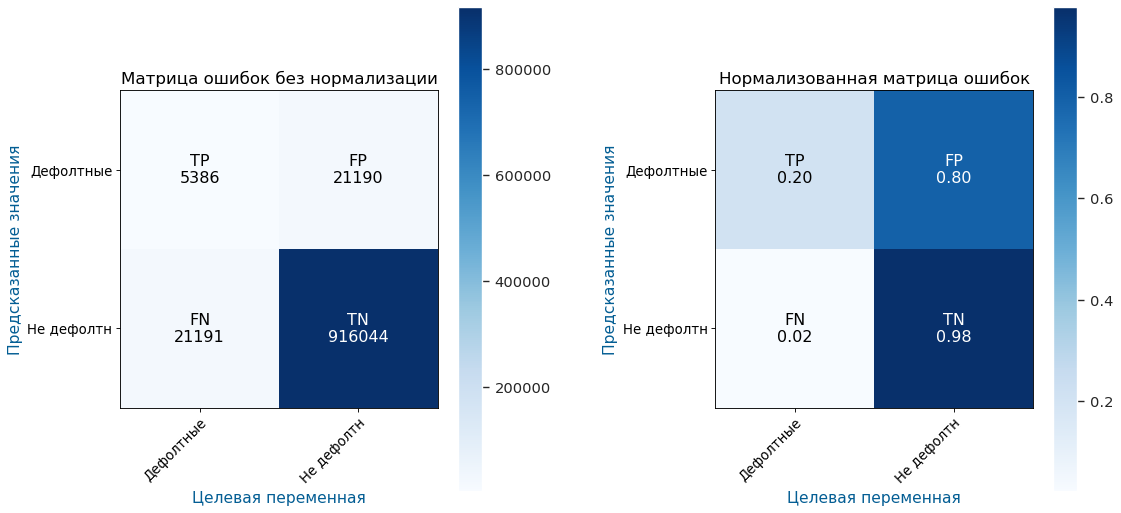

In [16]:
utils.plot_confusion_matrix_double(targets, targets_pred, 1.2, ['Дефолтные', 'Не дефолтные'])

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

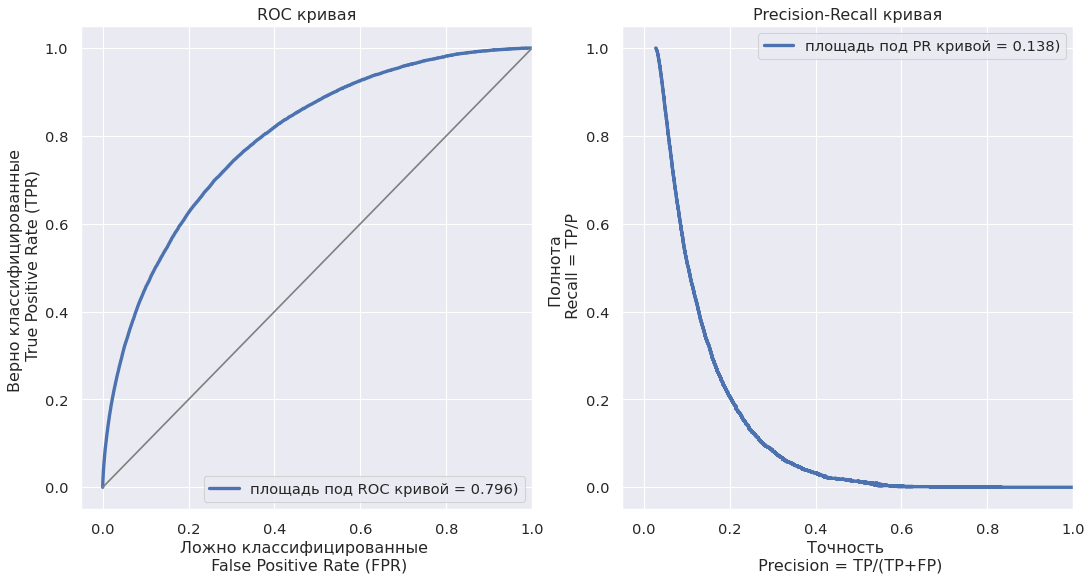

In [17]:
utils.ROC_and_PR_curves(targets, targets_pred_broba, 1.2)

# 5. Анализ второй модели (2)
---
## 5.1 Расчет прогноза дефолта 

In [18]:
%%time
features = feats_models[1]
lgb_models = models_LGBM[1]

targets_pred_broba = np.zeros(len(merged_train_data))

for model in tqdm.tqdm_notebook(lgb_models, desc='Прогноз по модели обученной на 5 фолдах:'):
    targets_pred_broba += model.predict(merged_train_data[features])/ len(lgb_models)

Прогноз по модели обученной на 5 фолдах::   0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 4min 43s, sys: 1.84 s, total: 4min 45s
Wall time: 1min 15s


## 5.2 Расчет бинарного вектора прогноза (targets_pred) из вероятностного прогноза (pred_proba)

In [19]:
sort_pred = sorted(targets_pred_broba)
border = sort_pred[sum_all_train-sum_defolt_train]
targets_pred = vfunc(targets_pred_broba, border)

## 5.3 Метрики, матрицы ошибок и кривые

In [20]:
temp_df = utils.all_metrics(targets, targets_pred, targets_pred_broba,len(features))
df_metrics['model2'] = temp_df['Значение']

,Значение,Дельта с предыдущим,Описание
Кол-во признаков,64.000000,63.000000,
accuracy,0.955874,0.000154,(TP+TN)/(P+N)
balanced accuracy,0.588592,0.001432,сбалансированная accuracy
precision,0.199880,0.002784,точность = TP/(TP+FP)
recall,0.199872,0.002784,полнота = TP/(TP+FN)
Ошибка II рода,0.800128,-0.002784,1 - полнота
f1_score,0.199876,0.002784,среднее гармоническое точности и полноты
roc_auc,0.792072,0.004244,площадь под ROC-кривой
roc_prc,0.135264,0.002618,площадь под PC-кривой


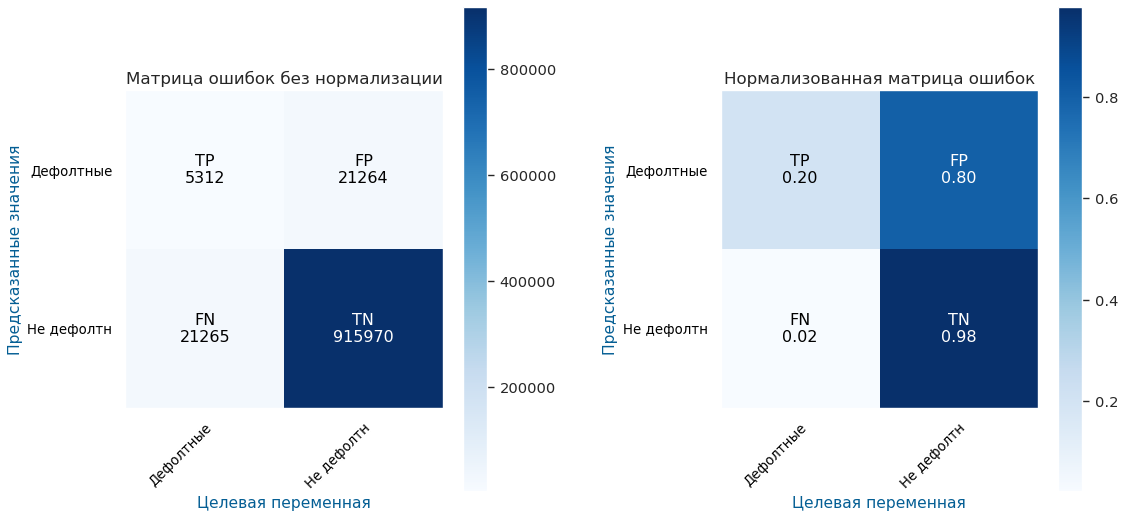

In [21]:
utils.plot_confusion_matrix_double(targets, targets_pred, 1.2, ['Дефолтные', 'Не дефолтные'])

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

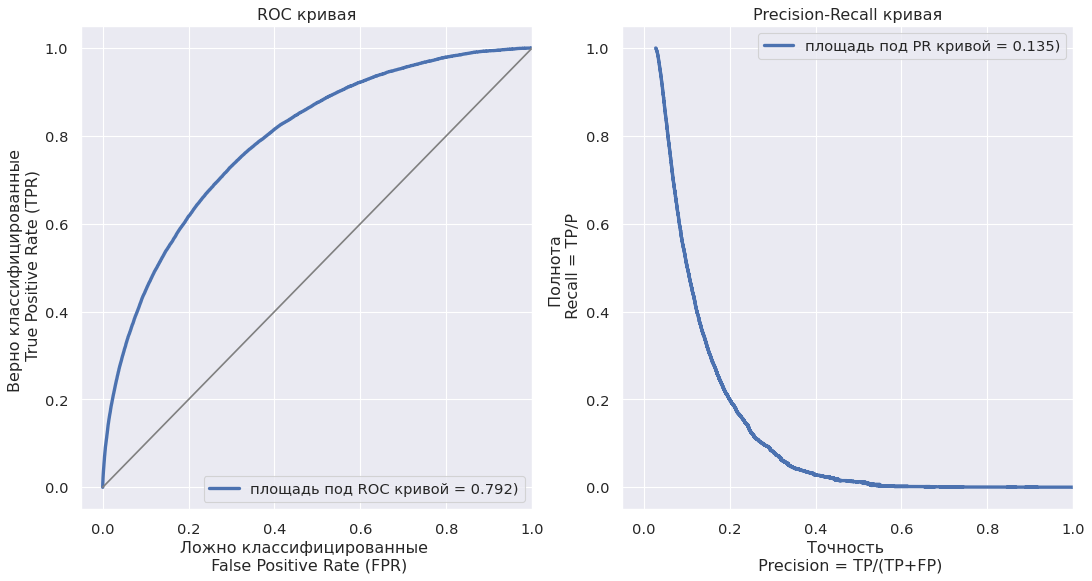

In [22]:
utils.ROC_and_PR_curves(targets, targets_pred_broba, 1.2)

# 6. Анализ третьей модели (3)
---
## 6.1 Расчет прогноза дефолта 

In [23]:
%%time
features = feats_models[2]
lgb_models = models_LGBM[2]

targets_pred_broba = np.zeros(len(merged_train_data))

for model in tqdm.tqdm_notebook(lgb_models, desc='Прогноз по модели обученной на 5 фолдах:'):
    targets_pred_broba += model.predict(merged_train_data[features])/ len(lgb_models)

Прогноз по модели обученной на 5 фолдах::   0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 4min 45s, sys: 1.81 s, total: 4min 47s
Wall time: 1min 15s


## 6.2 Расчет бинарного вектора прогноза (targets_pred) из вероятностного прогноза (pred_proba)

In [24]:
sort_pred = sorted(targets_pred_broba)
border = sort_pred[sum_all_train-sum_defolt_train]
targets_pred = vfunc(targets_pred_broba, border)

## 6.3 Метрики, матрицы ошибок и кривые

In [25]:
temp_df = utils.all_metrics(targets, targets_pred, targets_pred_broba,len(features))
df_metrics['model3'] = temp_df['Значение']

,Значение,Дельта с предыдущим,Описание
Кол-во признаков,59.000000,5.000000,
accuracy,0.955689,0.000185,(TP+TN)/(P+N)
balanced accuracy,0.586870,0.001722,сбалансированная accuracy
precision,0.196531,0.003349,точность = TP/(TP+FP)
recall,0.196523,0.003349,полнота = TP/(TP+FN)
Ошибка II рода,0.803477,-0.003349,1 - полнота
f1_score,0.196527,0.003349,среднее гармоническое точности и полноты
roc_auc,0.792188,-0.000116,площадь под ROC-кривой
roc_prc,0.132663,0.002601,площадь под PC-кривой


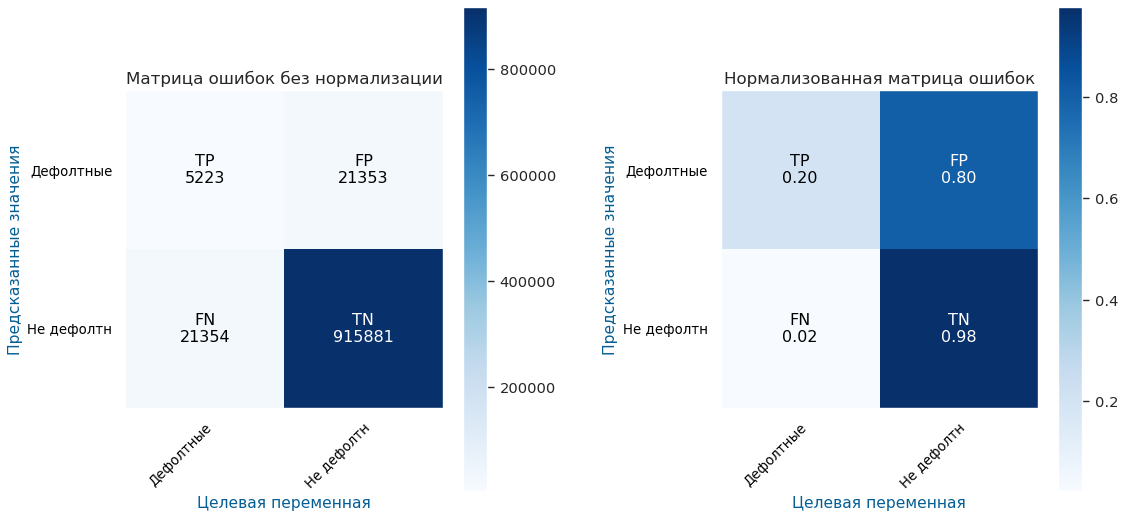

In [26]:
utils.plot_confusion_matrix_double(targets, targets_pred, 1.2, ['Дефолтные', 'Не дефолтные'])

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

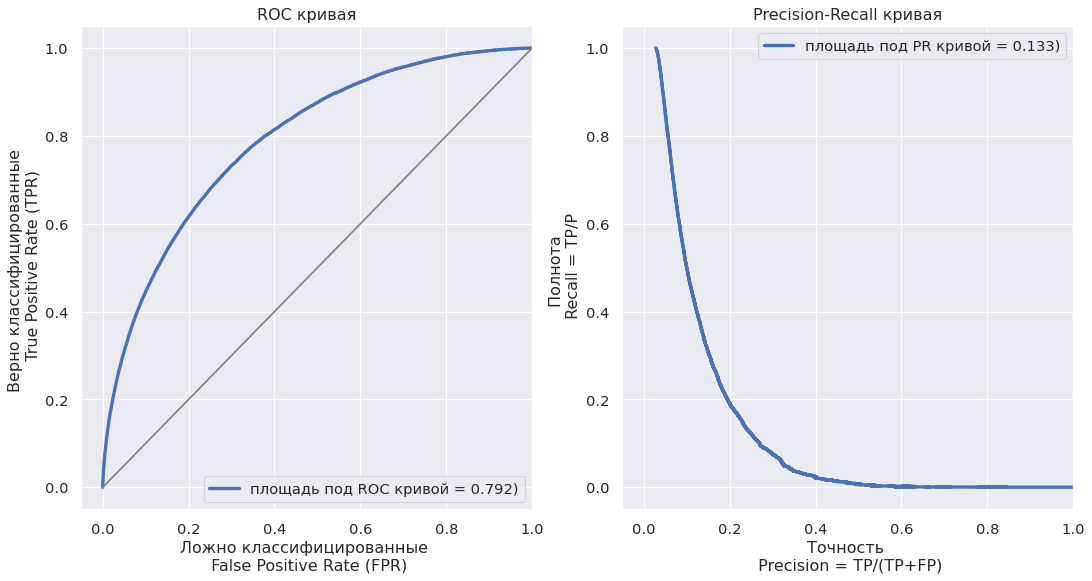

In [27]:
utils.ROC_and_PR_curves(targets, targets_pred_broba, 1.2)

# 7. Анализ четвертой модели (4)
---
## 7.1 Расчет прогноза дефолта 

In [28]:
%%time
features = feats_models[3]
lgb_models = models_LGBM[3]

targets_pred_broba = np.zeros(len(merged_train_data))

for model in tqdm.tqdm_notebook(lgb_models, desc='Прогноз по модели обученной на 5 фолдах:'):
    targets_pred_broba += model.predict(merged_train_data[features])/ len(lgb_models)

Прогноз по модели обученной на 5 фолдах::   0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 4min 49s, sys: 1.64 s, total: 4min 51s
Wall time: 1min 17s


## 7.2 Расчет бинарного вектора прогноза (targets_pred) из вероятностного прогноза (pred_proba)

In [29]:
sort_pred = sorted(targets_pred_broba)
border = sort_pred[sum_all_train-sum_defolt_train]
targets_pred = vfunc(targets_pred_broba, border)

## 7.3 Метрики, матрицы ошибок и кривые

In [30]:
temp_df = utils.all_metrics(targets, targets_pred, targets_pred_broba,len(features))
df_metrics['model4'] = temp_df['Значение']

,Значение,Дельта с предыдущим,Описание
Кол-во признаков,52.000000,7.000000,
accuracy,0.955646,0.000044,(TP+TN)/(P+N)
balanced accuracy,0.586464,0.000406,сбалансированная accuracy
precision,0.195741,0.000790,точность = TP/(TP+FP)
recall,0.195733,0.000790,полнота = TP/(TP+FN)
Ошибка II рода,0.804267,-0.000790,1 - полнота
f1_score,0.195737,0.000790,среднее гармоническое точности и полноты
roc_auc,0.787506,0.004682,площадь под ROC-кривой
roc_prc,0.132365,0.000298,площадь под PC-кривой


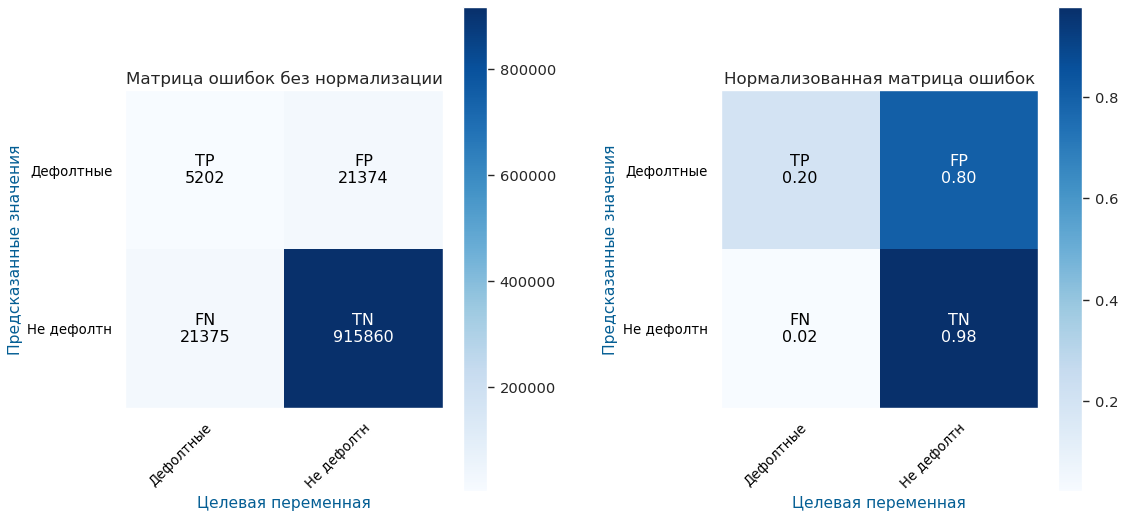

In [31]:
utils.plot_confusion_matrix_double(targets, targets_pred, 1.2, ['Дефолтные', 'Не дефолтные'])

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

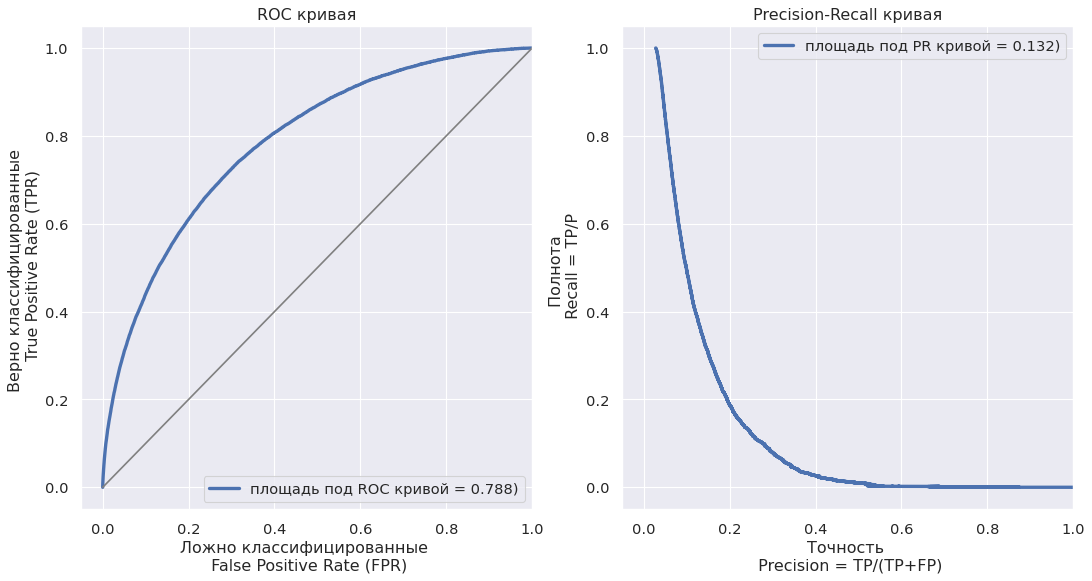

In [32]:
utils.ROC_and_PR_curves(targets, targets_pred_broba, 1.2)

# 8. Сводная таблица по метрикам моделей

In [33]:
df_metrics

,model1,model2,model3,model4
Кол-во признаков,127.000000,64.000000,59.000000,52.000000
accuracy,0.956028,0.955874,0.955689,0.955646
balanced accuracy,0.590024,0.588592,0.586870,0.586464
precision,0.202664,0.199880,0.196531,0.195741
recall,0.202656,0.199872,0.196523,0.195733
Ошибка II рода,0.797344,0.800128,0.803477,0.804267
f1_score,0.202660,0.199876,0.196527,0.195737
roc_auc,0.796315,0.792072,0.792188,0.787506
roc_prc,0.137881,0.135264,0.132663,0.132365


In [34]:
df_metrics.to_csv('metrics_models.csv', index=False)